In [1]:
###### Package installations to work on WIRE

! pip install mamba
! pip install pysankey
! mamba install gensim openai -y
! mamba install -c anaconda nltk -y
! mamba install -c conda-forge spacy -y
! mamba install -c conda-forge pyldavis -y
! mamba install -c conda-forge pypdf2 -y
! pip install transformers sentence-transformers
! pip install scikit-network
! pip install git+https://github.com/rwalk/gsdmm.git

! python -m spacy download en_core_web_sm

  Using cached mamba-0.11.2-py3-none-any.whl
  Using cached clint-0.5.1-py3-none-any.whl
  Using cached coverage-7.2.3-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (227 kB)
  Using cached args-0.1.0-py3-none-any.whl
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/usr/local/bin/coverage'
Consider using the `--user` option or check the permissions.

  Using cached pySankey-0.0.1-py3-none-any.whl (4.9 kB)
/bin/bash: line 1: mamba: command not found
/bin/bash: line 1: mamba: command not found
/bin/bash: line 1: mamba: command not found
/bin/bash: line 1: mamba: command not found
/bin/bash: line 1: mamba: command not found
  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-jb09s1wg
  Running command git clone --filter=blob:none --quiet https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-jb09s1wg
  Resolved https://github.com/rwalk/gsdmm.git to commit 4ad1b6b6976743681ee4976b4573463d35

In [3]:
# imports

import csv
import json
import os
import re
from pprint import pprint
import time
import re
import unicodedata
import os
import sys
from contextlib import contextmanager
from copy import deepcopy
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import SpectralEmbedding
import pickle
#import sknetwork as skn
from random import *

import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import pandas as pd


import nltk
nltk.download(["names", "stopwords", "state_union", "twitter_samples", "movie_reviews", "averaged_perceptron_tagger", "vader_lexicon", "punkt", "wordnet"])
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
ps = nltk.porter.PorterStemmer()

#from gsdmm import MovieGroupProcess

from sentence_transformers import SentenceTransformer

import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

from itertools import combinations

from scipy.spatial.distance import squareform
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import AgglomerativeClustering

# set seed for reproducibility
# np.random.seed(493)

[nltk_data] Downloading package names to C:\Users\Seth
[nltk_data]     Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Seth
[nltk_data]     Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to C:\Users\Seth
[nltk_data]     Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to C:\Users\Seth
[nltk_data]     Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to C:\Users\Seth
[nltk_data]     Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Seth Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package aver

In [83]:
cnn_list = ['final_processed_CNN_transcripts_llm_January2020.csv','final_processed_CNN_transcripts_llm_February2020.csv','final_processed_CNN_transcripts_llm_March2020.csv',
'final_processed_CNN_transcripts_llm_April2020.csv','final_processed_CNN_transcripts_llm_May2020.csv','final_processed_CNN_transcripts_llm_June2020.csv',
'final_processed_CNN_transcripts_llm_July2020.csv','final_processed_CNN_transcripts_llm_August2020.csv','final_processed_CNN_transcripts_llm_September2020.csv',
'final_processed_CNN_transcripts_llm_October2020.csv','final_processed_CNN_transcripts_llm_November2020.csv']
msnbc_list = ['final_processed_MSNBC_transcripts_llm_January2020.csv','final_processed_MSNBC_transcripts_llm_February2020.csv','final_processed_MSNBC_transcripts_llm_March2020.csv',
'final_processed_MSNBC_transcripts_llm_April2020.csv','final_processed_MSNBC_transcripts_llm_May2020.csv','final_processed_MSNBC_transcripts_llm_June2020.csv',
'final_processed_MSNBC_transcripts_llm_July2020.csv','final_processed_MSNBC_transcripts_llm_August2020.csv','final_processed_MSNBC_transcripts_llm_September2020.csv',
'final_processed_MSNBC_transcripts_llm_October2020.csv','final_processed_MSNBC_transcripts_llm_November2020.csv']
fox_list = ['final_processed_Fox_transcripts_llm_January2020.csv','final_processed_Fox_transcripts_llm_February2020.csv','final_processed_Fox_transcripts_llm_March2020.csv',
'final_processed_Fox_transcripts_llm_April2020.csv','final_processed_Fox_transcripts_llm_May2020.csv','final_processed_Fox_transcripts_llm_June2020.csv',
'final_processed_Fox_transcripts_llm_July2020.csv','final_processed_Fox_transcripts_llm_August2020.csv','final_processed_Fox_transcripts_llm_September2020.csv',
'final_processed_Fox_transcripts_llm_October2020.csv','final_processed_Fox_transcripts_llm_November2020.csv']


In [93]:
cnn = pd.read_csv(cnn_list[3])
msnbc = pd.read_csv(msnbc_list[3])
fox = pd.read_csv(fox_list[3])
trdf = cnn.append(msnbc)
trdf = trdf.append(fox)

C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\451906974.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\451906974.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


In [59]:

if 1 == 1:
    #keyword frequency
    trdf.Topic = trdf.Topic.apply(lambda x: x.strip('][').split(', '))
    trdf = trdf.explode('Topic').reset_index(drop=True)
    freq_df = trdf.pivot_table(index='Program', columns='Topic', values = 'Sentiment', aggfunc=len, fill_value=0)
    fdf = freq_df
    freq_df = freq_df.to_numpy()
    freq_df_2 = freq_df/freq_df.sum(axis=1)[:,None]
    freq_df_new = TfidfTransformer().fit_transform(freq_df_2).toarray()
    
    #keyword sentiment
    sent_df = trdf.pivot_table(index='Program', columns='Topic', values='avg_sentiment', aggfunc=np.mean, fill_value=0)
    sent = sent_df.to_numpy()
    #for i in range(sent.shape[0]):
     #   for j in range(sent.shape[1]):
      #      if freq[i][j] < 2:
       #         sent[i][j] = 0
    

    #get program simmilarities by topic
    program_topic_network = cosine_similarity(freq_df_new)
    #program_topic_network = np.matmul(freq_df_new, freq_df_new.T)
    
    
    #get program simmilarity by sentiment
    progs = sent_df.index
    program_sent_network = np.array([])
    c = 0
    for p in range(len(progs)):
        sp = sent[p]
        psim = []
        for p1 in range(len(progs)):
            p_p1 = []
            freq_p = 0
            sp1 = sent[p1]
            for w in range(len(sp)):
                  if sp[w] != 0 and sp1[w] != 0:
                        p_p1.append(((2 - abs(sp[w] - sp1[w]) )/ 2) * (freq_df[p][w] * freq_df[p1][w]))
                        freq_p += freq_df[p][w] * freq_df[p1][w]
            if len(p_p1) > 0:
                psim.append(sum(p_p1) /freq_p)
            else:
                psim.append(0)
                c += 1
            #print(len(p_p1))
        program_sent_network = np.append(program_sent_network, psim, axis=0)
    program_sent_network = (np.reshape(program_sent_network, [len(progs), len(progs)]) - program_sent_network.min()) / program_sent_network.max()

C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\3247164571.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\3247164571.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\3247164571.py:46: RuntimeWarning: invalid value encountered in scalar divide
  psim.append(sum(p_p1) /freq_p)


In [94]:
freq_list = trdf.groupby(['Topic'])['Transcript'].count()
freq_list = freq_list.sort_values(ascending = False)
freq_list[0:20]

Topic
CNN                  523
New York             399
Trump                365
China                303
U.S.                 285
Americans            232
the United States    207
Georgia              151
American             149
COVID-19             143
the White House      135
John                 103
Fauci                 88
CDC                   84
Anderson              75
Florida               70
New York City         61
Coronavirus           59
Wolf                  59
America               56
Name: Transcript, dtype: int64

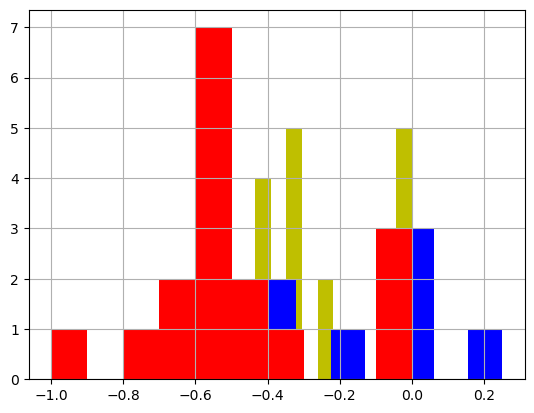

In [97]:
data = [cnn,msnbc,fox]
colors = ['y','b','r']
for i in range(len(data)):
    trdf = data[i]
    #print(trdf)
    #trdf.Topic = trdf.Topic.apply(lambda x: x.strip('][').split(', '))
    #trdf = trdf.explode('Topic').reset_index(drop=True)
    freq_df = trdf.pivot_table(index='Program', columns='Topic', values = 'Sentiment', aggfunc=len, fill_value=0)
    freq_df_new = TfidfTransformer().fit_transform(freq_df.to_numpy()).toarray()
    
    #keyword sentiment
    sent_df = trdf.pivot_table(index='Program', columns='Topic', values='avg_sentiment', aggfunc=np.mean, fill_value=0)
    sent_df["China"].hist(bins=10, color = colors[i])


In [622]:
trumpdf = trdf[trdf["Topic"] == "Trump"]
trumpdf = trumpdf.groupby("Program").mean()['Sentiment']
for r in trumpdf.index:
    print(r)
    print(trumpdf[r])

CNN ANDERSON COOPER 360 DEGREES
0.022843842537534523
CNN AT THIS HOUR
-0.021458115816109825
CNN CNN 10
-0.16575000000000006
CNN CNN LIVE EVENT/SPECIAL
0.09913687974198516
CNN CNN NEWSROOM
-0.01804433041058881
CNN CNN RELIABLE SOURCES
0.0524772742303992
CNN CNN RIGHT NOW
-0.011987370301656012
CNN CNN Special Reports
-0.05303492397660816
CNN CNN Tonight
-0.017241582582949926
CNN CUOMO PRIME TIME
0.03845543459341988
CNN EARLY START
0.012574822234163343
CNN ERIN BURNETT OUTFRONT
0.027302365864881436
CNN FAREED ZAKARIA GPS
0.011103311688311652
CNN Inside Politics
0.05902988673483804
CNN New Day
0.017595252477094068
CNN New Day Saturday
-0.060669328936656323
CNN New Day Sunday
-0.038313983396920694
CNN S.E. CUPP UNFILTERED
0.030734289903644765
CNN STATE OF THE UNION
-0.0439245469977177
CNN Smerconish
0.13294966954022983
CNN THE SITUATION ROOM
-0.03421612464984146
CNN The Lead with Jake Tapper
-0.06268267697267159
Fox News Network FOX AND FRIENDS
-0.29338
Fox News Network FOX HANNITY
-0.03733

/tmp/ipykernel_103/3245337645.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trumpdf = trumpdf.groupby("Program").mean()['Sentiment']


<Axes: >

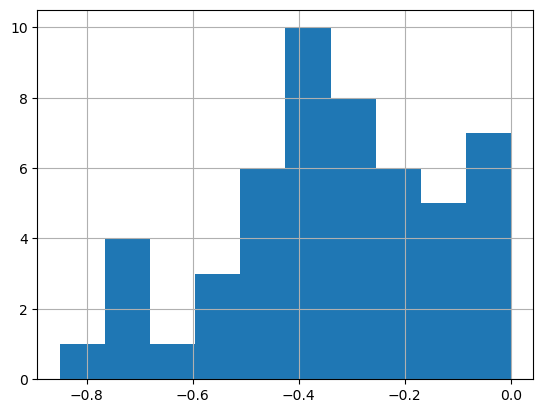

In [22]:
sent_df["Democrats"].hist(bins=10)

In [162]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
def get_clusters(trdf):
    #keyword frequency
    trdf.Topic = trdf.Topic.apply(lambda x: x.strip('][').split(', '))
    trdf = trdf.explode('Topic').reset_index(drop=True)
    freq_df = trdf.pivot_table(index='Program', columns='Topic', values = 'avg_sentiment', aggfunc=len, fill_value=0)
    freq_df = freq_df.to_numpy()
    freq_df_2 = freq_df/freq_df.sum(axis=1)[:,None]
    freq_df_new = TfidfTransformer().fit_transform(freq_df_2).toarray()
    
    #keyword sentiment
    sent_df = trdf.pivot_table(index='Program', columns='Topic', values='avg_sentiment', aggfunc=np.mean, fill_value=0)
    sent = sent_df.to_numpy()
    #for i in range(sent.shape[0]):
     #   for j in range(sent.shape[1]):
      #      if freq[i][j] < 2:
       #         sent[i][j] = 0
    

    #get program simmilarities by topic
    program_topic_network = cosine_similarity(freq_df_new)
    #program_topic_network = np.matmul(freq_df_new, freq_df_new.T)
    
    
    #get program simmilarity by sentiment
    progs = sent_df.index
    program_sent_network = np.array([])
    c = 0
    for p in range(len(progs)):
        sp = sent[p]
        psim = []
        for p1 in range(len(progs)):
            p_p1 = []
            freq_p = 0
            sp1 = sent[p1]
            for w in range(len(sp)):
                  if sp[w] != 0 and sp1[w] != 0:
                        p_p1.append(((2 - abs(sp[w] - sp1[w]) )/ 2) * (freq_df[p][w] * freq_df[p1][w]))
                        freq_p += freq_df[p][w] * freq_df[p1][w]
            if len(p_p1) > 0 and freq_p != 0:
                psim.append(sum(p_p1) /freq_p)
            else:
                psim.append(0)
                c += 1
        #print(psim)
        program_sent_network = np.append(program_sent_network, psim, axis=0)
    program_sent_network = (np.reshape(program_sent_network, [len(progs), len(progs)]) - program_sent_network.min()) / program_sent_network.max()
    print(program_sent_network)
    print(c)
    
    print(np.mean(program_topic_network))
    print(np.std(program_topic_network))
    print(np.mean(program_sent_network))
    print(np.std(program_sent_network))
    program_sim_network = np.multiply(program_topic_network, program_sent_network)
    #program_sim_network = program_topic_network
    #program_sim_network = program_topic_network + 3 * program_sent_network
    

    network_embedding = SpectralEmbedding(affinity='precomputed')
    print(network_embedding)
    pos_program_embeddings = network_embedding.fit_transform(program_sent_network/program_sent_network.max())
    program_df = pd.DataFrame()
    program_df['program'] = progs
    program_df['network'] = pd.Series(progs).apply(lambda x: x.split()[0])
    program_df['x_pos'] = pos_program_embeddings[:,0]
    program_df['y_pos'] = pos_program_embeddings[:,1]
    sns.scatterplot(data=program_df, x='x_pos', y='y_pos', hue='network')
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.title('Sentiment')
    plt.show()
    
    network_embedding = SpectralEmbedding(affinity='precomputed')
    print(network_embedding)
    pos_program_embeddings = network_embedding.fit_transform(program_topic_network/program_topic_network.max())
    program_df = pd.DataFrame()
    program_df['program'] = progs
    program_df['network'] = pd.Series(progs).apply(lambda x: x.split()[0])
    program_df['x_pos'] = pos_program_embeddings[:,0]
    program_df['y_pos'] = pos_program_embeddings[:,1]
    sns.scatterplot(data=program_df, x='x_pos', y='y_pos', hue='network')
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.title('Topic')
    plt.show()


    network_embedding = SpectralEmbedding(affinity='precomputed')
    print(network_embedding)
    pos_program_embeddings = network_embedding.fit_transform(program_sim_network/program_sim_network.max())
    program_df = pd.DataFrame()
    program_df['program'] = progs
    program_df['network'] = pd.Series(progs).apply(lambda x: x.split()[0])
    program_df['x_pos'] = pos_program_embeddings[:,0]
    program_df['y_pos'] = pos_program_embeddings[:,1]
    sns.scatterplot(data=program_df, x='x_pos', y='y_pos', hue='network')
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.title('Combined')
    plt.show()
    #network_embedding = SpectralEmbedding(affinity='precomputed')
    #pos_program_embeddings = network_embedding.fit_transform(program_sim_network/program_sim_network.max())
    
    #clustering
    #clustering = KMeans(n_clusters=5).fit(program_sim_network)
    #clustering = AgglomerativeClustering(n_clusters = 3).fit(program_sim_network)
    
    clustering = SpectralClustering(n_clusters = 3, affinity = 'precomputed').fit(program_sim_network)
    clust_df = pd.DataFrame(list(zip(progs, list(clustering.labels_))),
               columns =['Program', 'Cluster'])
    return clust_df

C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\3562359027.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\3562359027.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.94882572 0.93258512 ... 0.96698053 0.95756625 0.97792358]
 [0.94882572 1.         0.93797866 ... 0.94658263 0.92795147 0.9403989 ]
 [0.93258512 0.93797866 1.         ... 0.91387559 0.87824053 0.92637625]
 ...
 [0.96698053 0.94658263 0.91387559 ... 1.         0.9797066  0.97588137]
 [0.95756625 0.92795147 0.87824053 ... 0.9797066  1.         0.96523796]
 [0.97792358 0.9403989  0.92637625 ... 0.97588137 0.96523796 1.        ]]
86
0.3696860357698082
0.22373535098585265
0.8937325921978121
0.16986930601679875
SpectralEmbedding()


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


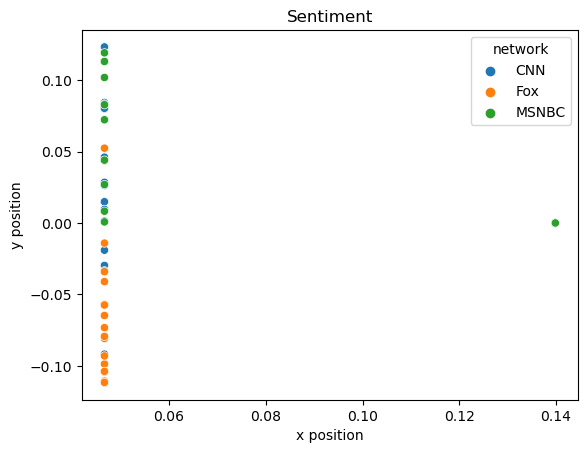

SpectralEmbedding(affinity='precomputed')


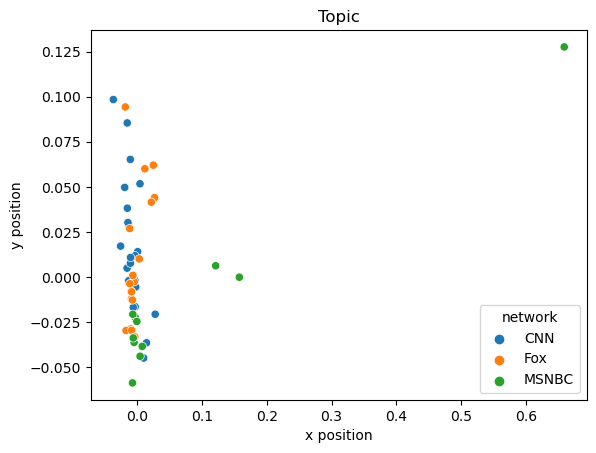

SpectralEmbedding(affinity='precomputed')


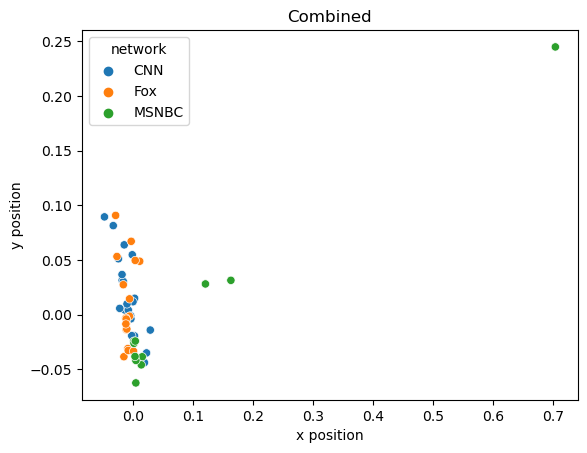

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\3562359027.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\3562359027.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.93188535 0.74707977 ... 0.92478392 0.92179394 0.9329347 ]
 [0.93188535 1.         0.93837053 ... 0.95840407 0.9246299  0.94162652]
 [0.74707977 0.93837053 1.         ... 0.87053571 0.93623306 0.88234677]
 ...
 [0.92478392 0.95840407 0.87053571 ... 1.         0.91358476 0.94526529]
 [0.92179394 0.9246299  0.93623306 ... 0.91358476 1.         0.93677102]
 [0.9329347  0.94162652 0.88234677 ... 0.94526529 0.93677102 1.        ]]
68
0.303419329800998
0.19037881454787098
0.8719656986272089
0.15766418343792707
SpectralEmbedding()


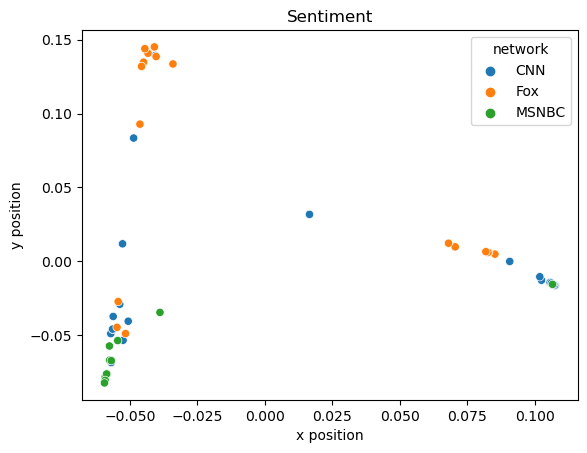

SpectralEmbedding(affinity='precomputed')


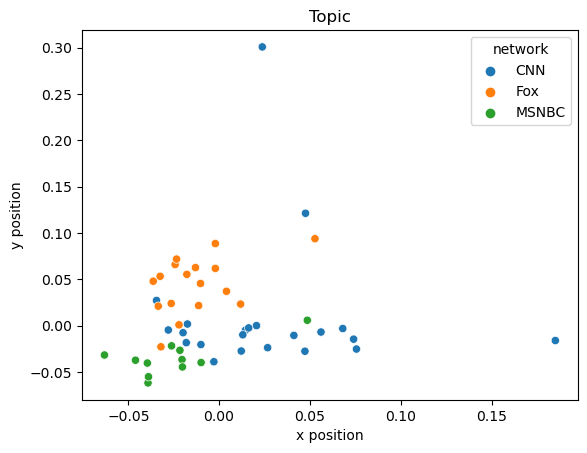

SpectralEmbedding(affinity='precomputed')


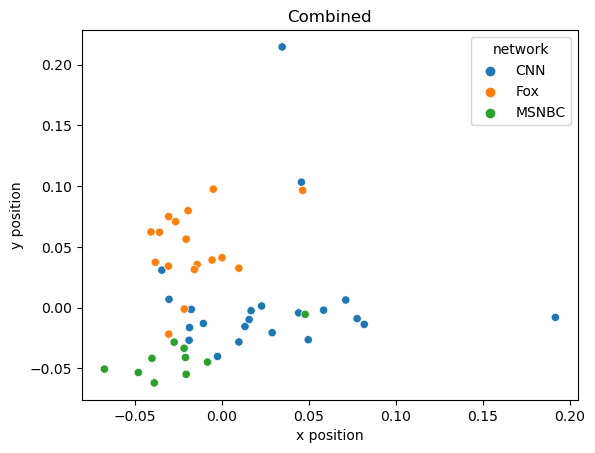

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\3562359027.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\3562359027.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.86991888 0.91604331 ... 0.91884527 0.93101264 0.93293423]
 [0.86991888 1.         0.88031591 ... 0.88038893 0.80871969 0.85633295]
 [0.91604331 0.88031591 1.         ... 0.92343027 0.92027558 0.95555443]
 ...
 [0.91884527 0.88038893 0.92343027 ... 1.         0.93887976 0.91891987]
 [0.93101264 0.80871969 0.92027558 ... 0.93887976 1.         0.9300029 ]
 [0.93293423 0.85633295 0.95555443 ... 0.91891987 0.9300029  1.        ]]
136
0.1890316428698957
0.16598040294859118
0.8336454989566217
0.21010399456602666
SpectralEmbedding()


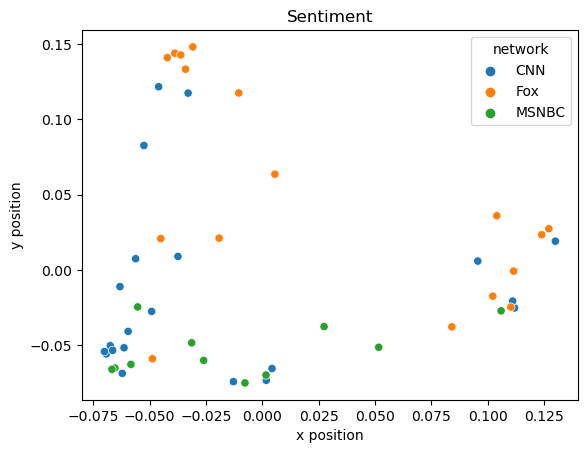

SpectralEmbedding(affinity='precomputed')


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


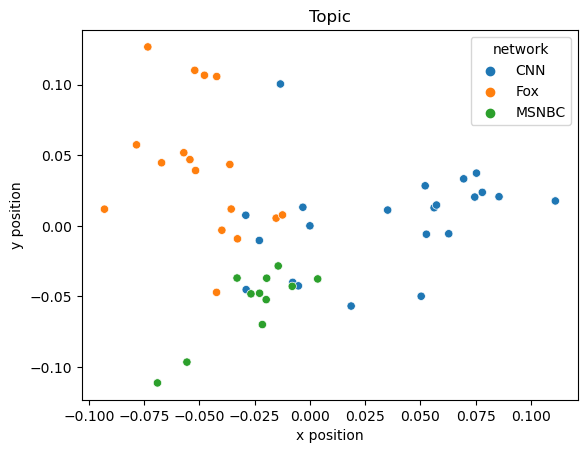

SpectralEmbedding(affinity='precomputed')


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


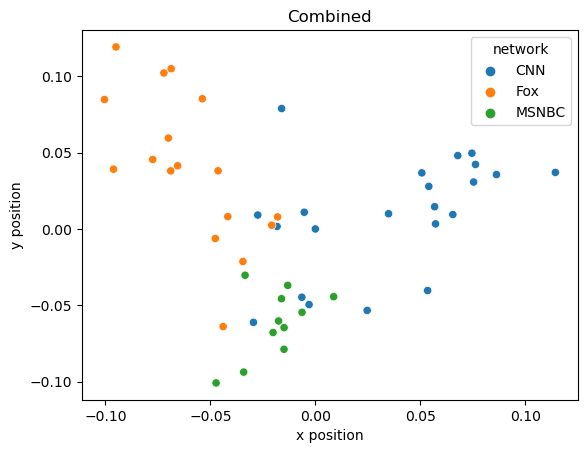

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\3562359027.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\3562359027.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.88047639 0.953942   ... 0.88968221 0.87395833 0.89530495]
 [0.88047639 1.         0.87164684 ... 0.91452789 0.8604363  0.79903307]
 [0.953942   0.87164684 1.         ... 0.83318712 0.93446393 0.94502803]
 ...
 [0.88968221 0.91452789 0.83318712 ... 1.         0.84579364 0.75266972]
 [0.87395833 0.8604363  0.93446393 ... 0.84579364 1.         0.9577335 ]
 [0.89530495 0.79903307 0.94502803 ... 0.75266972 0.9577335  1.        ]]
50
0.14428100611183964
0.16658671198341876
0.860687886120184
0.15005712489510634
SpectralEmbedding()


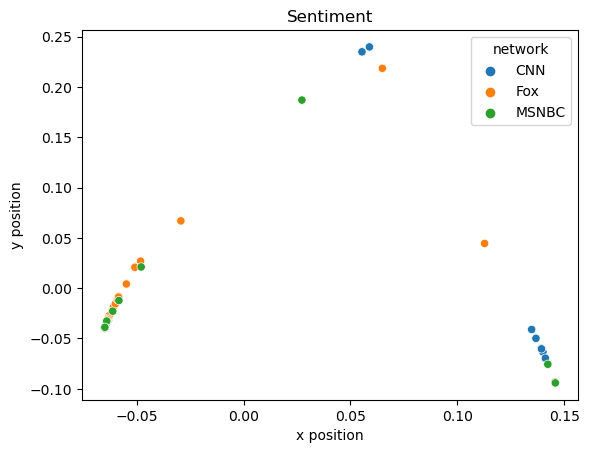

SpectralEmbedding(affinity='precomputed')


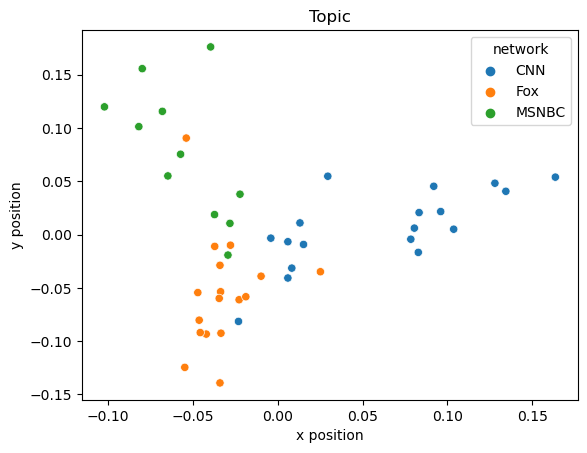

SpectralEmbedding(affinity='precomputed')


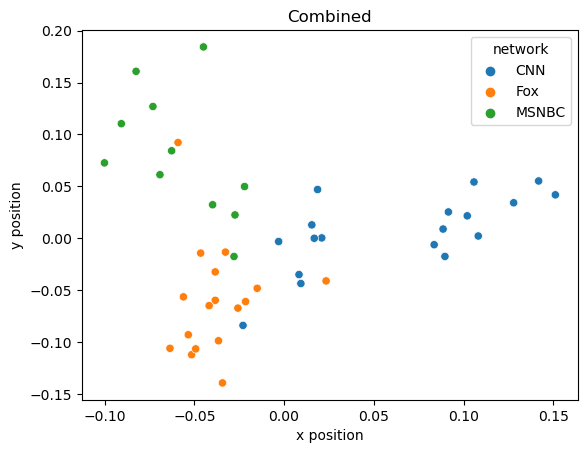

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\3562359027.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\3562359027.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.90339363 0.97392983 ... 0.95017512 0.95087435 0.92963024]
 [0.90339363 1.         0.89509683 ... 0.80691343 0.87732101 0.58220463]
 [0.97392983 0.89509683 1.         ... 0.85853081 0.91769475 0.90089179]
 ...
 [0.95017512 0.80691343 0.85853081 ... 1.         0.94751907 0.90831751]
 [0.95087435 0.87732101 0.91769475 ... 0.94751907 1.         0.90530514]
 [0.92963024 0.58220463 0.90089179 ... 0.90831751 0.90530514 1.        ]]
30
0.15137998856355428
0.16608322499132017
0.881152312117572
0.12622798302258637
SpectralEmbedding()


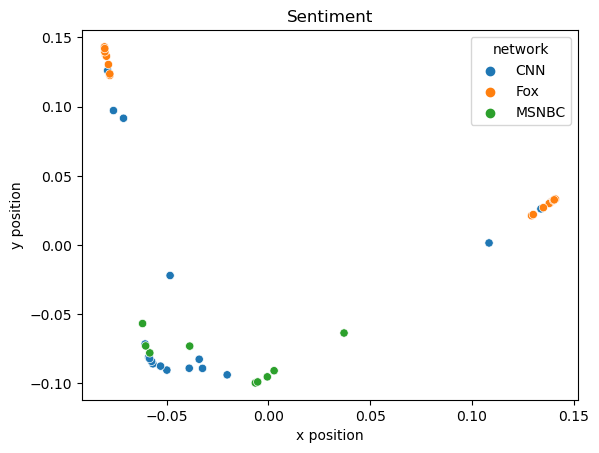

SpectralEmbedding(affinity='precomputed')


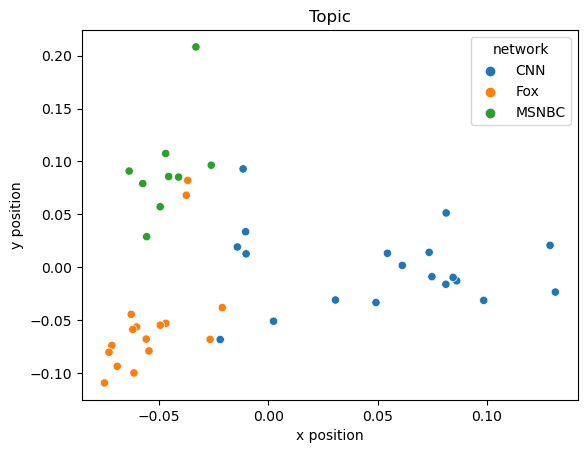

SpectralEmbedding(affinity='precomputed')


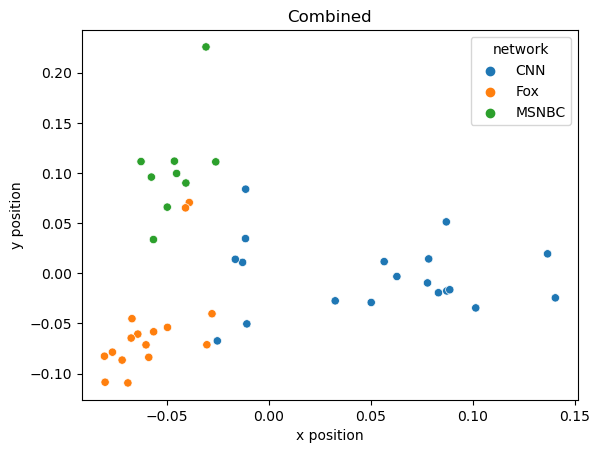

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KeyboardInterrupt: 

In [163]:
"""data = ['processed_transcripts_January2020.csv','processed_transcripts_February2020.csv','processed_transcripts_March2020.csv','processed_transcripts_April2020.csv',
       'processed_transcripts_May2020.csv','processed_transcripts_June2020.csv','processed_transcripts_July2020.csv','processed_transcripts_August2020.csv',
       'processed_transcripts_September2020.csv','processed_transcripts_October2020.csv', 'processed_transcripts_November2020.csv',] """
"""data = ['v9 processed_transcripts_January2020.csv','v9 processed_transcripts_February2020.csv','v9 processed_transcripts_March2020.csv',
       'v9 processed_transcripts_April2020.csv','v9 processed_transcripts_May2020.csv','v9 processed_transcripts_June2020.csv',
       'v9 processed_transcripts_July2020.csv','v9 processed_transcripts_August2020.csv',
       'v9 processed_transcripts_September2020.csv','new processed_transcripts_October2020.csv', 'new processed_transcripts_November2020.csv',]"""
"""data = ['new processed_transcripts_January2020.csv','new processed_transcripts_February2020.csv','new processed_transcripts_March2020.csv',
       'new processed_transcripts_April2020.csv','new processed_transcripts_May2020.csv','new processed_transcripts_June2020.csv',
       'new processed_transcripts_July2020.csv','new processed_transcripts_August2020.csv',
       'new processed_transcripts_September2020.csv','new processed_transcripts_October2020.csv', 'new processed_transcripts_November2020.csv',]"""
for i in range(11):#len(cnn_list)):
    cnn = pd.read_csv(cnn_list[i])
    msnbc = pd.read_csv(msnbc_list[i])
    fox = pd.read_csv(fox_list[i])
    trdf = cnn.append(msnbc)
    trdf = trdf.append(fox)
    trdf = trdf.dropna()
    clust_df = get_clusters(trdf)
    clust_df = clust_df.rename(columns={'Cluster': 'Cluster_' + str(i)})
    if i == 0:
        clusters_df = clust_df
    else:
        clusters_df = clusters_df.merge(clust_df, on = 'Program', how = 'left')
clusters_df.to_csv('clustersdf.csv')

In [147]:
#measuring
cnn = pd.read_csv(cnn_list[0])
msnbc = pd.read_csv(msnbc_list[0])
fox = pd.read_csv(fox_list[0])
trdf = cnn.append(msnbc)
trdf = trdf.append(fox)
ndf = trdf[trdf.isnull().any(axis=1)]
print(len(trdf))
print(len(ndf))

6998
184


C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\663590503.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_47732\663590503.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


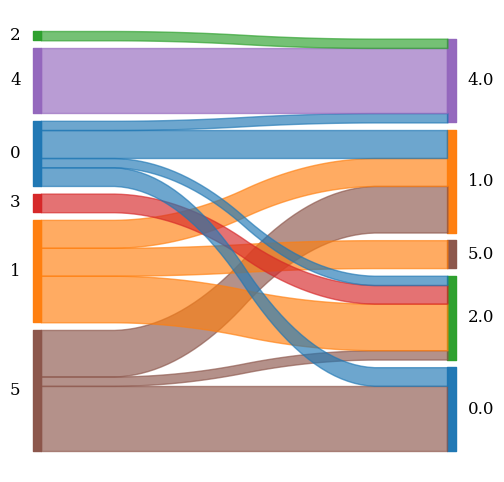

In [618]:
#print(clusters_df)
sankey_df = clusters_df.dropna()
#print(sankey_df)

from pySankey.sankey import sankey

pd.options.display.max_rows = 8

colorDict = {
    0:'#1f77b4',
    1:'#ff7f0e',
    2:'#2ca02c',
    3: '#d62728',
    4: '#9467bd',
    5: '#8c564b',
    6: '#f3f71b',
}
sankey(
    sankey_df['Cluster_0'],sankey_df['Cluster_5'], aspect=20, colorDict=colorDict,
    fontsize=12
)

In [101]:
for i,r in sankey_df.iterrows():
    print(r)

Program      CNN ANDERSON COOPER 360 DEGREES
Cluster_0                                  1
Cluster_1                                1.0
Cluster_2                                1.0
Cluster_3                                1.0
Cluster_4                                1.0
Name: 0, dtype: object
Program      CNN CNN 10
Cluster_0             2
Cluster_1           2.0
Cluster_2           0.0
Cluster_3           0.0
Cluster_4           0.0
Name: 2, dtype: object
Program      CNN CNN LIVE EVENT/SPECIAL
Cluster_0                             1
Cluster_1                           1.0
Cluster_2                           1.0
Cluster_3                           1.0
Cluster_4                           1.0
Name: 3, dtype: object
Program      CNN CNN NEWSROOM
Cluster_0                   1
Cluster_1                 1.0
Cluster_2                 1.0
Cluster_3                 1.0
Cluster_4                 1.0
Name: 4, dtype: object
Program      CNN CNN RELIABLE SOURCES
Cluster_0                           

In [19]:
sankey_df.to_csv('sankey_data.csv')

In [18]:
import plotly.graph_objects as go



fig = go.FigureWidget(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["A1", "A2", "A3","B1", "B2", "B3","C1", "C2","C3"],
      color = "blue"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

AttributeError: module 'plotly.graph_objects' has no attribute 'FigureWidget'

In [17]:
import pandas as pd
from floweaver import *
sankey_df['Count'] = 1
flows = (
    sankey_df.groupby(["Cluster_0", "Cluster_1", "Cluster_2","Cluster_3"])
    .agg({"Count": "count"})
    .dropna()
    .reset_index()
    .rename(
        columns={
            "Cluster_0": "source",
            "Cluster_1": "type",
            #"Cluster_2": "March",
            "Cluster_3": "target",
            "Count": "value",
        }
    )
)
print(flows)

# 1. Define a new waypoint node
nodes = {
    "January": ProcessGroup(sankey_df['Cluster_0'].unique().tolist()),
    "April":ProcessGroup(sankey_df['Cluster_3'].unique().tolist()),
}
nodes["February"] = Waypoint(sankey_df['Cluster_1'])
#nodes["March"] = Waypoint(sankey_df['Cluster_2'])

# 2. Update the ordering to show where the waypoint goes: in the middle
ordering = [
    ["January"],
    ["February"],
    #["March"],
    ["April"],
]

embark_port = Partition.Simple("process", flows["source"].unique().tolist())
disembark_port = Partition.Simple("process", flows["target"].unique().tolist())
cruise_region = Partition.Simple("type", flows.type.unique())

nodes["January"].partition = embark_port
nodes["April"].partition = disembark_port
nodes["February"].partition = cruise_region

# 3. Update the bundle definition to send the flows via the waypoint
bundles = [
    Bundle("January", "April", waypoints=["February"]),
]

# Update the SDD with the new nodes, ordering & bundles.
sdd = SankeyDefinition(nodes, bundles, ordering)

weave(sdd, flows, link_color=QuantitativeScale("value", palette='Blues_9')).to_widget().auto_save_png(
    "waypoint.png"
)

    source  type  Cluster_2  target  value
0        0   0.0        2.0     0.0      4
1        0   2.0        1.0     1.0      1
2        0   2.0        2.0     0.0      2
3        1   1.0        0.0     0.0      3
..     ...   ...        ...     ...    ...
8        2   1.0        0.0     0.0      2
9        2   1.0        0.0     1.0      2
10       2   2.0        0.0     0.0      3
11       2   2.0        2.0     0.0      3

[12 rows x 5 columns]


/tmp/ipykernel_9157/1686510773.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sankey_df['Count'] = 1


SankeyWidget(groups=[{'id': 'January', 'type': 'process', 'title': '', 'nodes': ['January^0', 'January^1', 'Ja…